# NLP Homework2

In [1]:
!wc -l "hw2_data/snli_train.tsv"

  100001 hw2_data/snli_train.tsv


In [1]:
!wc -l "hw2_data/snli_val.tsv"

    1001 hw2_data/snli_val.tsv


In [10]:
! head -1 'snli_train_first1000.tsv'

sentence1	sentence2	label


In [2]:
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter 
# import pickle as pkl 
import random
import pdb 
random.seed(134)

words_to_load = 50000
# PAD_IDX = 0
# UNK_IDX = 1
BATCH_SIZE = 32
MAX_SENTENCE_LENGTH = 20

train_path = 'hw2_data/snli_train.tsv'
val_path = 'hw2_data/snli_val.tsv'

# 1. Read Data

In [3]:
import csv

def load_pretrained_embed(pretrained_file):
    '''
    load the pretrained word embeddings
    Returns:
    loaded_embed: a numpy array with shape words_to_load*300
    words2idx: a dictionary where key is word and value is index
    idx2words: a dictionary where key is index and value is word
    '''
    with open(pretrained_file) as f:
        next(f) #skip the first line header
        loaded_embed = np.zeros((words_to_load, 300))
        words2idx = {}
        idx2words = {}
        ordered_words = []
        for i, line in enumerate(f):
            if i >= words_to_load: 
                break
            s = line.split() #split to word and its corresponding pretrained vector
            loaded_embed[i, :] = np.asarray(s[1:])
            words2idx[s[0]] = i
            idx2words[i] = s[0]
            ordered_words.append(s[0])

    return loaded_embed, words2idx, idx2words

def data_split(filename):
    '''
    splits the datafile into premise, hypothesis and corresponding labels
    Returns:
    premise: a list of premise sentences
    hypoth: a list of hypothesis sentences
    labels: a list of labels
    '''
    premise = []
    hypoth = []
    labels = []
    with open (filename,'r') as tsvfile:
        tsvreader = csv.reader(tsvfile,delimiter='\t')
        for line in tsvreader:
            premise.append(line[0].split())
            hypoth.append(line[1].split())
            labels.append(line[2])
            
    return premise[1:], hypoth[1:], labels[1:] #skip the first line

def sentence2vectors(sentence,words2idx,loaded_embed):
    '''
    converts a sentence to a vector of word embeddings
    Returns:
    sentence_vect: a numpy array of sentence embeddings with size sentence_length S * 300
    '''
    sentence_vect = np.zeros((len(sentence),300))
    for i,word in enumerate(sentence):
        if word in words2idx:
            sentence_vect[i,:] = loaded_embed[words2idx[word]]

    return sentence_vect

def textdata2vectors(data,words2idx,loaded_embed):
    '''
    converts all the text sentences to vectorized embeddings
    Returns: a numpy array with shape number of datapoints D *[ S * 300 ]
    '''
    return np.asarray([sentence2vectors(sentence,words2idx,loaded_embed) for sentence in data])


def label2idx(labels):
    '''
    converts text labels to indices
    entailment 0, contradiction 1, neutral 2
    '''
    label_id = np.zeros(len(labels))
    for i, label in enumerate(labels):
        if label == 'contradiction': label_id[i] = 1
        if label == 'neutral': label_id[i] = 2
            
    return label_id
    
def read_data(file):
    premise, hypothesis,label = data_split(file)
    loaded_embed, words2idx, idx2words = load_pretrained_embed('wiki-news-300d-1M.vec')
    premise_vects = textdata2vectors(premise,words2idx,loaded_embed)
    hypothesis_vects = textdata2vectors(hypothesis,words2idx,loaded_embed)
    labels = label2idx(label)
    
    return premise_vects, hypothesis_vects, labels

def load_train_val_data(trainfile, valfile):
    '''
    Returns:
    premise_train: (data_length, ) [ S * 300 ]
    '''
    premise_train, hypothesis_train, label_train= read_data(trainfile)
    premise_val, hypothesis_val, label_val = read_data(valfile)
    
    return premise_train, hypothesis_train, label_train,\
        premise_val, hypothesis_val, label_val
    

In [4]:
#preprocess the dataset
premise_train, hypothesis_train, label_train,\
premise_val, hypothesis_val, label_val = load_train_val_data(train_path,val_path)

In [5]:
print('training size: {}'.format(premise_train.shape))
print('validation size: {}'.format(premise_val.shape))

training size: (100000,)
validation size: (1000,)


In [10]:
premise_train[0]

array([[-0.0595, -0.0428,  0.06  , ...,  0.0235,  0.215 ,  0.0581],
       [ 0.038 , -0.0449, -0.0897, ...,  0.0795,  0.0255, -0.027 ],
       [-0.0433, -0.0663, -0.0548, ...,  0.0326,  0.2213,  0.0096],
       ...,
       [-0.0063, -0.0253, -0.0338, ...,  0.1155,  0.0073,  0.0168],
       [ 0.0324,  0.1127,  0.0299, ...,  0.0468,  0.1144, -0.0125],
       [ 0.0004,  0.0032, -0.0204, ...,  0.207 ,  0.0689, -0.0467]])

In [9]:
premise_train[0].shape

(17, 300)

# 2. Construct Pytorch Pipeline

In [76]:
class Dataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, premise_list, hypothesis_list, target_list):
        """
        @param premise_list: list of sentences
        @param hypothesis_list: list of sentences
        @param target_list: list of labels
        """
        self.premise_list = premise_list
        self.hypothesis_list = hypothesis_list
        self.target_list = target_list
        assert (len(self.premise_list) == len(self.target_list)), "premise_list length not equal to label_list length"
        assert (len(self.hypothesis_list) == len(self.target_list)), "hypothesis_list length not match label_list length"
        
    def __len__(self):
        '''
        returns number of data points in the dataset
        '''
        return len(self.premise_list)

    def __getitem__(self, idx):
        """
        Triggered when you call dataset[idx]
        returns a list consists of a premise and the corresponiding hypothesis sentence trim by MAX_SENTENCE_LENGTH,
        their lengths and label
        """
        premise_vect = self.premise_list[idx][:MAX_SENTENCE_LENGTH,:] ##
        hypoth_vect = self.hypothesis_list[idx][:MAX_SENTENCE_LENGTH,:] ##
        label = self.target_list[idx]
        
        return [premise_vect, hypoth_vect,premise_vect.shape[0], hypoth_vect.shape[0],label]

def pad_sentence(sentence):
    '''
    returns padded sentence in a numpy array format (size MAX_SENTENCE_LENGTH*300)
    '''
    padded_sentence = np.zeros((MAX_SENTENCE_LENGTH,300))
    for idx, word in enumerate(sentence):
        padded_sentence[idx,:] = word 
        
    return padded_sentence
    
def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    @param batch: size B*S*300
    Returns: collated list[]
    x1_list: list of premise sentences in FloatTensor type (size B*MAX_SENTENCE_LENGTH*300)
    x2_list: list of hypothesis sentences in FloatTensor type (size B*MAX_SENTENCE_LENGTH*300)
    x1_length_list: LongTensor (size B*I)
    x2_length_list: LongTensor (size B*I)
    label_list: LongTensor (size B*I)
    """
    x1_list = []
    x2_list = []
    x1_length_list = []
    x2_length_list = []
    label_list = []

    for datum in batch:
#         x1 is datum[0] shape = S*300
#         x2 is datum[1] shape = S*300
        x1_length_list.append(datum[2])
        x2_length_list.append(datum[3])
        label_list.append(datum[4])
    
    # padding
    for datum in batch:
        x1_padded = pad_sentence(datum[0])
        x1_list.append(x1_padded)
        x2_padded = pad_sentence(datum[1])
        x2_list.append(x2_padded)
        
    collated = [torch.from_numpy(np.array(x1_list)).float(), torch.from_numpy(np.array(x2_list)).float(), ##
                torch.LongTensor(x1_length_list), torch.LongTensor(x2_length_list),
                torch.LongTensor(label_list)]
    
    return collated

In [77]:
# Build train and valid dataloaders

train_dataset = Dataset(premise_train, hypothesis_train,label_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn = collate_func,
                                           shuffle=True)

val_dataset = Dataset(premise_val, hypothesis_val, label_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=BATCH_SIZE,
                                         collate_fn = collate_func,
                                         shuffle=True)

In [8]:
len(train_dataset)

100000

In [9]:
len(val_dataset)

1000

# 3. Build RNN Model

In [19]:
tensor = torch.LongTensor([7,1,3,2])
sorted_tensor, sort_idx = torch.sort(tensor,descending = True)
_,unsort_idx = torch.sort(sort_idx)
print(sorted_tensor)
print(tensor.index_select(0,sort_idx))
print(sorted_tensor.index_select(0,unsort_idx))

tensor([7, 3, 2, 1])
tensor([7, 3, 2, 1])
tensor([7, 1, 3, 2])


In [78]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size,output_size,num_layers = 1,bidirectional = True):##
        '''
        This rnn consists of one layer of bidirectional gru and 2 fully connected layers
        Arg:
        input_size: input size
        hidden_size: size of hidden layer in RNN
        '''
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        #one layer of bidirectional gru
        self.gru = nn.GRU(input_size, hidden_size, num_layers, 
                          bidirectional = bidirectional ,batch_first = True) #batch_first??
        
        #two fully connected layers
        self.fc1 = nn.Linear(2*hidden_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, output_size) 
       
    def init_hidden(self, batch_size):
        # initializes the activation of rnn at timestep 0
        hidden = torch.zeros(2,batch_size,self.hidden_size) 
        return hidden

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        '''
        x1 x2 shape: B * S * embed
        bidirectional gru --> fc --> relu --> fc --> softmax
        '''
        batch_size = x1.size(0)
        
        #make an initial hidden layer 
        #x1_hidden shape = 2*B*h
        x1_hidden = self.init_hidden(batch_size)  ##??
        x2_hidden = self.init_hidden(batch_size)

        #sort padded batch sentences by length
        #x1_sorted shape = B*S*embed
        x1_idx_sort, x1_idx_unsort, x1_sorted = sort_sentences(x1,x1_lengths)
        x2_idx_sort, x2_idx_unsort, x2_sorted = sort_sentences(x2,x2_lengths)
       
        # feed though RNN
        #Output shape: x1_out (B*S*600) x1_hidden (2*B*h)
        x1_out, x1_hidden = self.gru(x1_sorted, x1_hidden)  ##??
        x2_out, x2_hidden = self.gru(x2_sorted, x2_hidden)  
        
        # take the last hidden state and unsort x1 and x2
        # Output x1_hidden (2*B*h)
        x1_hidden = x1_hidden.index_select(1,x1_idx_unsort)
        x2_hidden = x2_hidden.index_select(1,x2_idx_unsort)
    
        # concat x1_hidden and x2_hidden
        # Output concat (2*B*(2h))
        concat = torch.cat((x1_hidden,x2_hidden),dim = 2)
        
        # sum the two direction hidden activations of RNN 
        # Output gru_out (B*(2h))
        gru_out = torch.sum(concat, dim=0) 
        
        #first fully connected layer with relu 
        # Output fc1_out (B*h)
        fc1_out = F.relu(self.fc1(gru_out), inplace=True) 
        
        #second fully connected layer
        # Output fc2_out (B*output_size)
        fc2_out = self.fc2(fc1_out)
        
        return F.softmax(fc2_out,dim=1)

def sort_sentences(sentences, sentence_lengths):
    '''
    sort the padded batch by sentence length in descending order
    @param sentences: the batch of sentences, type = Tensor
    @param sentence_lengths: the list of sentence lengths data , type = LongTensor
    @param labels: the corresponding list of labels, type = LongTensor
    Returns
    sorted_sentences: Tensor 
    '''
    #store the sorted and unsorted index 
    _, idx_sort = torch.sort(torch.LongTensor(sentence_lengths),descending = True)
    _, idx_unsort = torch.sort(torch.LongTensor(idx_sort))
        
    #sort the sentences of the batch
    sorted_sentences = sentences.index_select(0,idx_sort)
        
    return idx_sort, idx_unsort, sorted_sentences

In [79]:
def train_rnn_model(train_loader, num_epochs,optimizer,learning_rate, hidden_size):
    
    model = RNN(input_size = 300, hidden_size = hidden_size, output_size = 3)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    if optimizer == 'Adam': optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if optimizer == 'SGD': optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Train the model
    val_acc_history = []
    train_acc_history = []
    
    for epoch in range(num_epochs):
        for i, (premise, hypoth, premise_len, hypoth_len,labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(premise, hypoth, premise_len, hypoth_len)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            # validate 
            if i > 0 and i % (12*BATCH_SIZE) == 0:
                train_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc:{5}, Validation Acc: {6}'.format(
                            epoch+1, num_epochs, i+1, len(train_loader),loss.item(), train_acc, val_acc))
    
    print('RNN Training Finished!')
    print ("Val Acc {}".format(test_model(val_loader, model)))
    
    return model,train_acc_history, val_acc_history

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for i, (x1, x2, x1_len, x2_len,labels) in enumerate(loader):
        if i > 100: break #only compute the average accuracy on 100 batches
        x1_batch,x2_batch,x1_lens,x2_lens,label_batch = x1, x2, x1_len, x2_len,labels
        outputs = model(x1_batch,x2_batch,x1_lens,x2_lens) 
        #get the predicted labels
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)   

# 4. Build CNN Model

In [80]:
class CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers , output_size, kernel_size, padding):

        super(CNN, self).__init__()
        
        self.input_size = input_size
        self.num_layers = num_layers ##
        self.hidden_size = hidden_size
        self.kernel_size, self.padding = kernel_size, padding

        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size, padding)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding)
        
        self.fc1 = nn.Linear(hidden_size*2, hidden_size) ##
        self.fc2 = nn.Linear(hidden_size,output_size)

    def forward(self, x1,x2, x1_lengths,x2_lengths):
        '''
        Inputs x1, x2: B*S*embed
        conv1d --> relu --> conv1d --> relu --> maxpool1d --> fc -->relu --> fc --> softmax
        '''
        
        batch_size, sentence_len, embed = x1.size()
        channel1 = sentence_len - self.kernel_size + self.padding
        channel2 = channel1 - self.kernel_size + self.padding
        
        #sort padded batch sentences by length
        #Ouput: x1/x2_sorted (B*S*embed)
        x1_idx_sort, x1_idx_unsort, x1_sorted = sort_sentences(x1,x1_lengths)
        x2_idx_sort, x2_idx_unsort, x2_sorted = sort_sentences(x2,x2_lengths)
        
        #feed through conv layer1
        #Conv1d module expect input of size (B*embed*S) 
        # Inputs (B*S*embed) --> (B*embed*S)
        # Output x1/x2_hidden (B* h*C1) --> (B*C1*h)
        x1_hidden = self.conv1(x1_sorted.transpose(1,2)).transpose(1,2)
        x1_hidden = F.relu(x1_hidden.contiguous().view(-1, x1_hidden.size(-1))).view(batch_size, channel1, x1_hidden.size(-1))##??
        x2_hidden = self.conv1(x2_sorted.transpose(1,2)).transpose(1,2)
        x2_hidden = F.relu(x2_hidden.contiguous().view(-1, x2_hidden.size(-1))).view(batch_size, channel1, x2_hidden.size(-1))
        
        #feed through conv layer2
        #Inputs x1/x2_hidden (B*C1*h) --> (B* h*C1)
        #Outputs x1/x2_hidden (B*h*C2) --> (B*C2*h)
        x1_hidden = self.conv2(x1_hidden.transpose(1,2)).transpose(1,2)
        x1_hidden = F.relu(x1_hidden.contiguous().view(-1, x1_hidden.size(-1))).view(batch_size, channel2, x1_hidden.size(-1))
        x2_hidden = self.conv2(x2_hidden.transpose(1,2)).transpose(1,2)
        x2_hidden = F.relu(x2_hidden.contiguous().view(-1, x2_hidden.size(-1))).view(batch_size, channel2, x2_hidden.size(-1))
        
        #feed through a maxpooling layer pool over the time dimension
        # Outputs (B*h)
        x1_hidden = F.max_pool1d(x1_hidden.transpose(1,2),kernel_size=channel2).squeeze(dim=2) ##??
        x2_hidden = F.max_pool1d(x2_hidden.transpose(1,2),kernel_size=channel2).squeeze(dim=2)
        
        # take the outputs and unsort x1 and x2
        # Outputs (B*h)
        x1_hidden = x1_hidden.index_select(0,x1_idx_unsort)
        x2_hidden = x2_hidden.index_select(0,x2_idx_unsort)
        
        #concat x1 and x2
        # Outputs (B*(2h))
        concat = torch.cat((x1_hidden,x2_hidden),dim = 1)

        #feed through 2 fully connected layers
        fc1_out = F.relu(self.fc1(concat),inplace=True) ##??
        fc2_out = self.fc2(fc1_out)
        
        return F.softmax(fc2_out,dim=1)


In [81]:
def train_cnn_model(train_loader, num_epochs,optimizer,learning_rate, hidden_size, kernel_size,padding):
    
    model = CNN(input_size = 300, hidden_size = hidden_size, output_size = 3, kernel_size=kernel_size, num_layers = 2,padding=padding)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    if optimizer == 'Adam': optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if optimizer == 'SGD': optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Train the model
    val_acc_history = []
    train_acc_history = []

    for epoch in range(num_epochs):
        for i, (premise, hypoth, premise_len, hypoth_len,labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(premise, hypoth, premise_len, hypoth_len)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            # validate 
            if i > 0 and i % (BATCH_SIZE*12) == 0:
                # validate
                train_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)
                
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Train Acc:{5}, Validation Acc: {6}'.format(
                            epoch+1, num_epochs, i+1, len(train_loader),loss.item(), train_acc, val_acc))
    
    print('CNN Training Finished!')
    print ("Val Acc {}".format(test_model(val_loader, model)))
    
    return model, train_acc_history, val_acc_history

# 5. Train Models

#### 1.RNN

In [72]:
rnn_model1, train_acc_history_rnn, val_acc_history_rnn = train_rnn_model(train_loader, num_epochs=10,
                                                                optimizer='Adam',learning_rate = 3e-4,
                                                                hidden_size = 100)

Epoch: [1/10], Step: [385/3125], Loss: 1.029064416885376, Train Acc:49.87623762376238, Validation Acc: 50.6
Epoch: [1/10], Step: [769/3125], Loss: 0.8562949299812317, Train Acc:55.97153465346535, Validation Acc: 56.9
Epoch: [1/10], Step: [1153/3125], Loss: 0.9602564573287964, Train Acc:59.03465346534654, Validation Acc: 58.0
Epoch: [1/10], Step: [1537/3125], Loss: 0.9547593593597412, Train Acc:59.71534653465346, Validation Acc: 58.7
Epoch: [1/10], Step: [1921/3125], Loss: 0.9818050861358643, Train Acc:58.91089108910891, Validation Acc: 58.0
Epoch: [1/10], Step: [2305/3125], Loss: 0.8472523093223572, Train Acc:58.972772277227726, Validation Acc: 60.3
Epoch: [1/10], Step: [2689/3125], Loss: 0.9878230690956116, Train Acc:60.86014851485149, Validation Acc: 59.4
Epoch: [1/10], Step: [3073/3125], Loss: 1.001197099685669, Train Acc:61.850247524752476, Validation Acc: 59.6
Epoch: [2/10], Step: [385/3125], Loss: 0.9153162837028503, Train Acc:61.633663366336634, Validation Acc: 61.1
Epoch: [2/10

Epoch: [10/10], Step: [1537/3125], Loss: 0.719541609287262, Train Acc:72.61757425742574, Validation Acc: 68.3
Epoch: [10/10], Step: [1921/3125], Loss: 0.9393689632415771, Train Acc:73.36014851485149, Validation Acc: 67.8
Epoch: [10/10], Step: [2305/3125], Loss: 0.8632984757423401, Train Acc:72.3700495049505, Validation Acc: 68.7
Epoch: [10/10], Step: [2689/3125], Loss: 0.8417478799819946, Train Acc:72.89603960396039, Validation Acc: 68.3
Epoch: [10/10], Step: [3073/3125], Loss: 0.7046139240264893, Train Acc:73.39108910891089, Validation Acc: 69.0
RNN Training Finished!
Val Acc 68.6


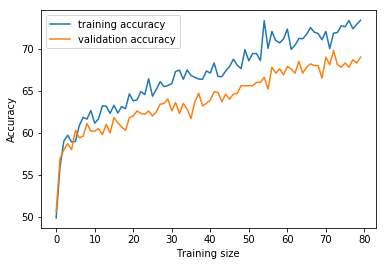

In [74]:
import matplotlib.pyplot as plt
plt.plot(train_acc_history_rnn,label = 'training accuracy')
plt.plot(val_acc_history_rnn,label = 'validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training size')
plt.legend()
plt.savefig('train_val_acc_rnn2.png')

#### 2. CNN

In [81]:
cnn_model1, train_acc_history_cnn, val_acc_history_cnn = train_cnn_model(train_loader, num_epochs = 10,optimizer='Adam',
                                                                        learning_rate = 3e-4 , hidden_size = 100,
                                                                        kernel_size = 5 ,padding=1)

Epoch: [1/10], Step: [385/3125], Loss: 1.0543683767318726, Train Acc:57.17821782178218, Validation Acc: 55.8
Epoch: [1/10], Step: [769/3125], Loss: 0.9412168860435486, Train Acc:59.96287128712871, Validation Acc: 58.1
Epoch: [1/10], Step: [1153/3125], Loss: 1.0392779111862183, Train Acc:58.23019801980198, Validation Acc: 57.2
Epoch: [1/10], Step: [1537/3125], Loss: 0.9718529582023621, Train Acc:60.51980198019802, Validation Acc: 58.2
Epoch: [1/10], Step: [1921/3125], Loss: 0.8968530893325806, Train Acc:59.870049504950494, Validation Acc: 59.4
Epoch: [1/10], Step: [2305/3125], Loss: 1.0014519691467285, Train Acc:62.96410891089109, Validation Acc: 58.9
Epoch: [1/10], Step: [2689/3125], Loss: 0.8921328186988831, Train Acc:63.49009900990099, Validation Acc: 60.6
Epoch: [1/10], Step: [3073/3125], Loss: 1.0964221954345703, Train Acc:62.5, Validation Acc: 60.3
Epoch: [2/10], Step: [385/3125], Loss: 0.9838056564331055, Train Acc:63.056930693069305, Validation Acc: 58.7
Epoch: [2/10], Step: [76

Epoch: [10/10], Step: [1537/3125], Loss: 0.8246607184410095, Train Acc:75.77351485148515, Validation Acc: 62.0
Epoch: [10/10], Step: [1921/3125], Loss: 0.681667149066925, Train Acc:79.88861386138613, Validation Acc: 62.5
Epoch: [10/10], Step: [2305/3125], Loss: 0.7807638645172119, Train Acc:77.84653465346534, Validation Acc: 62.1
Epoch: [10/10], Step: [2689/3125], Loss: 0.8180723786354065, Train Acc:77.35148514851485, Validation Acc: 60.9
Epoch: [10/10], Step: [3073/3125], Loss: 0.9208360910415649, Train Acc:78.80569306930693, Validation Acc: 62.2
CNN Training Finished!
Val Acc 61.6


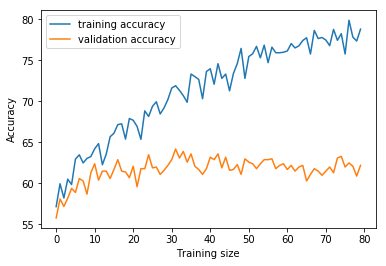

In [82]:
plt.plot(train_acc_history_cnn,label = 'training accuracy')
plt.plot(val_acc_history_cnn,label = 'validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training size')
plt.legend()
plt.savefig('train_val_acc_cnn1.png')

# 6. Hyperparameters Tunning

At least two of the following:
* hidden_size
* kernel_size
* interaction between two sentences: concatenation, element-wise multiplication
* Regularization: weight decay, dropout

### 1. Hidden_size

In [83]:
hidden_size_list = [100,300,600]
rnn_hidden_size_tunning_train_hist = []
rnn_hidden_size_tunning_val_hist = []
cnn_hidden_size_tunning_train_hist = []
cnn_hidden_size_tunning_val_hist = []

for hidden_size in hidden_size_list:
    print('hidden_size = {}'.format(hidden_size))
    print('RNN')
    rnn_model, train_acc_history_rnn, val_acc_history_rnn = train_rnn_model(train_loader, num_epochs=10,
                                                                            optimizer='Adam',
                                                                            learning_rate = 3e-4,
                                                                            hidden_size = hidden_size)
    rnn_hidden_size_tunning_train_hist.append(train_acc_history_rnn)
    rnn_hidden_size_tunning_val_hist.append(val_acc_history_rnn)
    print('CNN')
    cnn_model, train_acc_history_cnn, val_acc_history_cnn = train_cnn_model(train_loader, num_epochs = 10,
                                                                            optimizer='Adam',
                                                                            learning_rate = 3e-4 , 
                                                                            hidden_size = hidden_size,
                                                                            kernel_size = 5 ,padding=1)
    cnn_hidden_size_tunning_train_hist.append(train_acc_history_cnn)
    cnn_hidden_size_tunning_val_hist.append(val_acc_history_cnn)

hidden_size = 100
RNN
Epoch: [1/10], Step: [385/3125], Loss: 1.0370500087738037, Train Acc:49.00990099009901, Validation Acc: 48.6
Epoch: [1/10], Step: [769/3125], Loss: 0.964037299156189, Train Acc:55.97153465346535, Validation Acc: 55.6
Epoch: [1/10], Step: [1153/3125], Loss: 0.9079391956329346, Train Acc:56.992574257425744, Validation Acc: 57.0
Epoch: [1/10], Step: [1537/3125], Loss: 0.9924478530883789, Train Acc:59.28217821782178, Validation Acc: 57.6
Epoch: [1/10], Step: [1921/3125], Loss: 0.9292033910751343, Train Acc:59.931930693069305, Validation Acc: 56.9
Epoch: [1/10], Step: [2305/3125], Loss: 1.1333880424499512, Train Acc:58.879950495049506, Validation Acc: 56.2
Epoch: [1/10], Step: [2689/3125], Loss: 0.8788550496101379, Train Acc:59.65346534653465, Validation Acc: 58.1
Epoch: [1/10], Step: [3073/3125], Loss: 0.8391460180282593, Train Acc:59.56064356435643, Validation Acc: 58.1
Epoch: [2/10], Step: [385/3125], Loss: 0.8379420638084412, Train Acc:60.79826732673267, Validation

Epoch: [10/10], Step: [1537/3125], Loss: 0.7564377784729004, Train Acc:71.93688118811882, Validation Acc: 69.4
Epoch: [10/10], Step: [1921/3125], Loss: 0.8625821471214294, Train Acc:73.26732673267327, Validation Acc: 69.2
Epoch: [10/10], Step: [2305/3125], Loss: 0.7428489327430725, Train Acc:72.89603960396039, Validation Acc: 68.3
Epoch: [10/10], Step: [2689/3125], Loss: 0.8029606938362122, Train Acc:73.01980198019803, Validation Acc: 68.0
Epoch: [10/10], Step: [3073/3125], Loss: 0.7949779033660889, Train Acc:73.20544554455445, Validation Acc: 68.0
RNN Training Finished!
Val Acc 69.3
CNN
Epoch: [1/10], Step: [385/3125], Loss: 1.0732920169830322, Train Acc:53.743811881188115, Validation Acc: 54.2
Epoch: [1/10], Step: [769/3125], Loss: 1.0548745393753052, Train Acc:57.271039603960396, Validation Acc: 55.2
Epoch: [1/10], Step: [1153/3125], Loss: 0.9551694393157959, Train Acc:58.23019801980198, Validation Acc: 57.5
Epoch: [1/10], Step: [1537/3125], Loss: 0.8859894871711731, Train Acc:61.23

Epoch: [9/10], Step: [2689/3125], Loss: 0.7782853245735168, Train Acc:78.52722772277228, Validation Acc: 64.4
Epoch: [9/10], Step: [3073/3125], Loss: 0.7831044793128967, Train Acc:75.99009900990099, Validation Acc: 63.4
Epoch: [10/10], Step: [385/3125], Loss: 0.7904549241065979, Train Acc:78.0940594059406, Validation Acc: 63.9
Epoch: [10/10], Step: [769/3125], Loss: 0.8631832599639893, Train Acc:76.85643564356435, Validation Acc: 64.2
Epoch: [10/10], Step: [1153/3125], Loss: 0.7770348787307739, Train Acc:77.38242574257426, Validation Acc: 63.5
Epoch: [10/10], Step: [1537/3125], Loss: 0.8624410033226013, Train Acc:77.84653465346534, Validation Acc: 63.2
Epoch: [10/10], Step: [1921/3125], Loss: 0.8821459412574768, Train Acc:77.81559405940594, Validation Acc: 63.7
Epoch: [10/10], Step: [2305/3125], Loss: 0.6736634969711304, Train Acc:78.0940594059406, Validation Acc: 63.3
Epoch: [10/10], Step: [2689/3125], Loss: 0.7994210720062256, Train Acc:77.32054455445545, Validation Acc: 63.3
Epoch: 

Epoch: [9/10], Step: [769/3125], Loss: 0.808552622795105, Train Acc:76.29950495049505, Validation Acc: 68.4
Epoch: [9/10], Step: [1153/3125], Loss: 0.8539742827415466, Train Acc:75.12376237623762, Validation Acc: 67.9
Epoch: [9/10], Step: [1537/3125], Loss: 0.8060265183448792, Train Acc:76.23762376237623, Validation Acc: 69.0
Epoch: [9/10], Step: [1921/3125], Loss: 0.8095453381538391, Train Acc:75.71163366336634, Validation Acc: 68.8
Epoch: [9/10], Step: [2305/3125], Loss: 0.8667348623275757, Train Acc:76.02103960396039, Validation Acc: 68.2
Epoch: [9/10], Step: [2689/3125], Loss: 0.8265435099601746, Train Acc:75.74257425742574, Validation Acc: 69.4
Epoch: [9/10], Step: [3073/3125], Loss: 0.9105080962181091, Train Acc:75.83539603960396, Validation Acc: 68.8
Epoch: [10/10], Step: [385/3125], Loss: 0.806550145149231, Train Acc:76.33044554455445, Validation Acc: 70.9
Epoch: [10/10], Step: [769/3125], Loss: 0.75030118227005, Train Acc:76.82549504950495, Validation Acc: 68.3
Epoch: [10/10],

Epoch: [8/10], Step: [1921/3125], Loss: 0.8023648858070374, Train Acc:79.33168316831683, Validation Acc: 64.9
Epoch: [8/10], Step: [2305/3125], Loss: 0.695744514465332, Train Acc:79.42450495049505, Validation Acc: 64.9
Epoch: [8/10], Step: [2689/3125], Loss: 0.7967638969421387, Train Acc:80.29084158415841, Validation Acc: 64.6
Epoch: [8/10], Step: [3073/3125], Loss: 0.737602710723877, Train Acc:78.37252475247524, Validation Acc: 63.6
Epoch: [9/10], Step: [385/3125], Loss: 0.7058006525039673, Train Acc:79.45544554455445, Validation Acc: 65.5
Epoch: [9/10], Step: [769/3125], Loss: 0.7859002947807312, Train Acc:81.40470297029702, Validation Acc: 65.8
Epoch: [9/10], Step: [1153/3125], Loss: 0.792442798614502, Train Acc:81.03341584158416, Validation Acc: 65.5
Epoch: [9/10], Step: [1537/3125], Loss: 0.8754734992980957, Train Acc:80.7240099009901, Validation Acc: 65.5
Epoch: [9/10], Step: [1921/3125], Loss: 0.7754524350166321, Train Acc:81.03341584158416, Validation Acc: 66.4
Epoch: [9/10], S

Epoch: [7/10], Step: [3073/3125], Loss: 0.8457874059677124, Train Acc:76.54702970297029, Validation Acc: 68.3
Epoch: [8/10], Step: [385/3125], Loss: 0.8031809329986572, Train Acc:76.70173267326733, Validation Acc: 68.2
Epoch: [8/10], Step: [769/3125], Loss: 0.8250656127929688, Train Acc:75.74257425742574, Validation Acc: 69.6
Epoch: [8/10], Step: [1153/3125], Loss: 0.9555231928825378, Train Acc:77.66089108910892, Validation Acc: 69.7
Epoch: [8/10], Step: [1537/3125], Loss: 0.780723512172699, Train Acc:77.5680693069307, Validation Acc: 68.4
Epoch: [8/10], Step: [1921/3125], Loss: 0.7879176735877991, Train Acc:77.01113861386139, Validation Acc: 68.8
Epoch: [8/10], Step: [2305/3125], Loss: 0.855111837387085, Train Acc:76.14480198019803, Validation Acc: 68.4
Epoch: [8/10], Step: [2689/3125], Loss: 0.7618672847747803, Train Acc:76.70173267326733, Validation Acc: 68.1
Epoch: [8/10], Step: [3073/3125], Loss: 0.7559446096420288, Train Acc:76.14480198019803, Validation Acc: 67.9
Epoch: [9/10], 

Epoch: [7/10], Step: [1153/3125], Loss: 0.8301292657852173, Train Acc:79.05321782178218, Validation Acc: 65.3
Epoch: [7/10], Step: [1537/3125], Loss: 0.7063774466514587, Train Acc:79.36262376237623, Validation Acc: 67.7
Epoch: [7/10], Step: [1921/3125], Loss: 0.8639504909515381, Train Acc:79.57920792079207, Validation Acc: 66.7
Epoch: [7/10], Step: [2305/3125], Loss: 0.761158287525177, Train Acc:80.16707920792079, Validation Acc: 67.2
Epoch: [7/10], Step: [2689/3125], Loss: 0.8140770792961121, Train Acc:78.52722772277228, Validation Acc: 67.4
Epoch: [7/10], Step: [3073/3125], Loss: 0.8872457146644592, Train Acc:79.51732673267327, Validation Acc: 67.0
Epoch: [8/10], Step: [385/3125], Loss: 0.8591869473457336, Train Acc:79.1769801980198, Validation Acc: 66.6
Epoch: [8/10], Step: [769/3125], Loss: 0.6967099905014038, Train Acc:80.41460396039604, Validation Acc: 65.6
Epoch: [8/10], Step: [1153/3125], Loss: 0.7889446020126343, Train Acc:81.25, Validation Acc: 67.0
Epoch: [8/10], Step: [1537

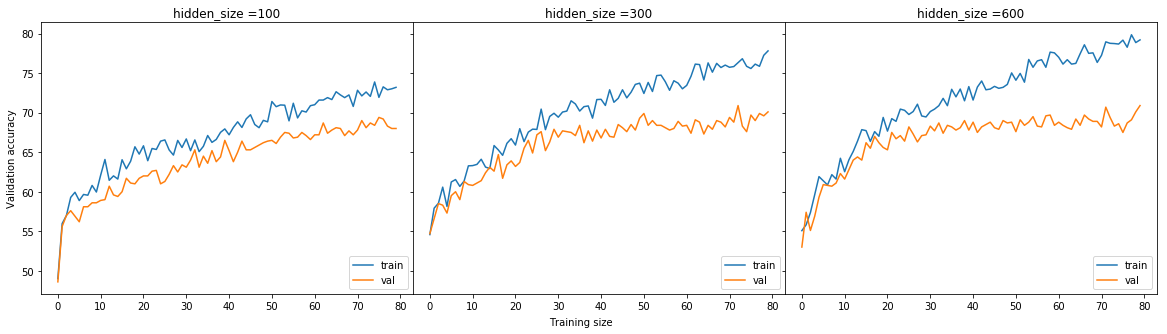

In [154]:
fig, axes = plt.subplots(1,3, sharey = True,sharex = True,figsize=(20, 5))
fig.text( 0.5, 0.04,'Training size', ha='center')
for i in range(3):
    axes[i].plot(rnn_hidden_size_tunning_train_hist[i],label='train')
    axes[i].plot(rnn_hidden_size_tunning_val_hist[i],label='val')
    axes[i].set_title('hidden_size ='+ str(hidden_size_list[i]))  
    axes[i].legend(loc = 'lower right')
plt.subplots_adjust(wspace=0, hspace=None)
axes[0].set_ylabel('Validation accuracy')
plt.savefig('hidden_size tunning for RNN.png')

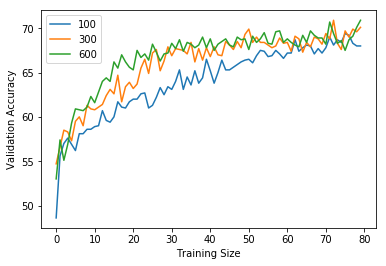

In [162]:
for i in range(3):
    plt.plot(rnn_hidden_size_tunning_val_hist[i],label=hidden_size_list[i])
plt.xlabel('Training Size')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.savefig('hidden_size tunning for RNN val acc.png')

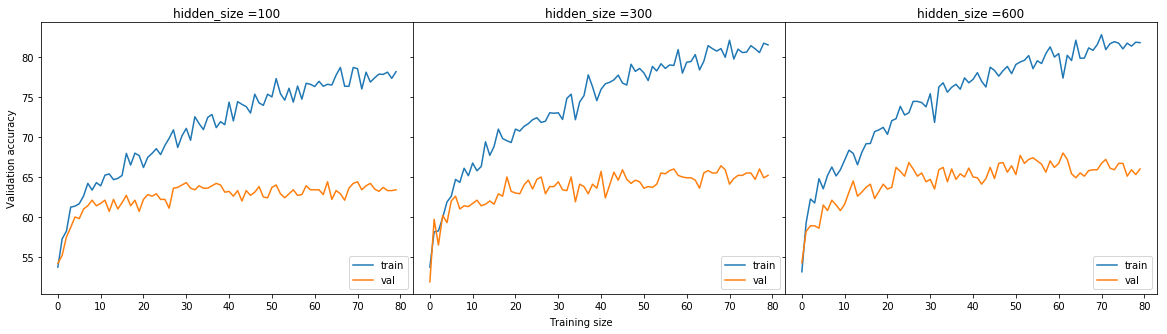

In [155]:
fig, axes = plt.subplots(1,3, sharex = True, sharey = True,figsize=(20, 5))
fig.text( 0.5, 0.04,'Training size', ha='center')
for i in range(3):
    axes[i].plot(cnn_hidden_size_tunning_train_hist[i],label='train')
    axes[i].plot(cnn_hidden_size_tunning_val_hist[i],label='val')
    axes[i].set_title('hidden_size ='+ str(hidden_size_list[i]))
    axes[i].legend(loc = 'lower right')
plt.subplots_adjust(wspace=0, hspace=None)
axes[0].set_ylabel('Validation accuracy')
plt.savefig('hidden_size tunning for CNN.png')


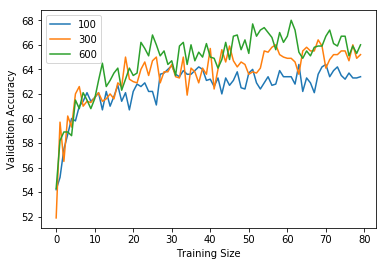

In [163]:
for i in range(3):
    plt.plot(cnn_hidden_size_tunning_val_hist[i],label=hidden_size_list[i])
plt.xlabel('Training Size')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.savefig('hidden_size tunning for CNN val acc.png')

300 is much better than 100. The val accuracy doesn't raise much when hidden_size = 600 compared to the one for 300. 
--> choose hidden size 300. 

### 2. Kernel Size

In [156]:
kernel_size_list = [3,5,10]
cnn_kernel_size_tunning_train_hist = []
cnn_kernel_size_tunning_val_hist = []

for kernel_size in kernel_size_list :
    print('kernel_size = {}'.format(kernel_size))

    print('CNN')
    cnn_model, train_acc_history_cnn, val_acc_history_cnn = train_cnn_model(train_loader, num_epochs = 10,
                                                                            optimizer='Adam',
                                                                            learning_rate = 3e-4 , 
                                                                            hidden_size = 300,
                                                                            kernel_size = kernel_size ,padding=1)
    cnn_kernel_size_tunning_train_hist.append(train_acc_history_cnn)
    cnn_kernel_size_tunning_val_hist.append(val_acc_history_cnn)
    

kernel_size = 3
CNN
Epoch: [1/10], Step: [385/3125], Loss: 0.9330279231071472, Train Acc:56.18811881188119, Validation Acc: 54.9
Epoch: [1/10], Step: [769/3125], Loss: 0.9917826652526855, Train Acc:59.931930693069305, Validation Acc: 57.3
Epoch: [1/10], Step: [1153/3125], Loss: 0.8970205187797546, Train Acc:60.9220297029703, Validation Acc: 58.4
Epoch: [1/10], Step: [1537/3125], Loss: 0.8923059105873108, Train Acc:62.80940594059406, Validation Acc: 59.5
Epoch: [1/10], Step: [1921/3125], Loss: 1.0385520458221436, Train Acc:63.118811881188115, Validation Acc: 61.9
Epoch: [1/10], Step: [2305/3125], Loss: 0.8125448226928711, Train Acc:63.89232673267327, Validation Acc: 61.5
Epoch: [1/10], Step: [2689/3125], Loss: 0.9816004037857056, Train Acc:63.0259900990099, Validation Acc: 60.0
Epoch: [1/10], Step: [3073/3125], Loss: 0.9112827181816101, Train Acc:65.87252475247524, Validation Acc: 61.5
Epoch: [2/10], Step: [385/3125], Loss: 0.8706293106079102, Train Acc:65.87252475247524, Validation Acc

Epoch: [10/10], Step: [1537/3125], Loss: 0.7127488851547241, Train Acc:80.87871287128714, Validation Acc: 68.6
Epoch: [10/10], Step: [1921/3125], Loss: 0.8173699975013733, Train Acc:80.01237623762377, Validation Acc: 67.4
Epoch: [10/10], Step: [2305/3125], Loss: 0.7233335375785828, Train Acc:79.23886138613861, Validation Acc: 67.9
Epoch: [10/10], Step: [2689/3125], Loss: 0.7989125847816467, Train Acc:80.84777227722772, Validation Acc: 68.1
Epoch: [10/10], Step: [3073/3125], Loss: 0.7583425641059875, Train Acc:80.7240099009901, Validation Acc: 66.8
CNN Training Finished!
Val Acc 65.8
kernel_size = 5
CNN
Epoch: [1/10], Step: [385/3125], Loss: 0.9815376996994019, Train Acc:57.51856435643565, Validation Acc: 55.8
Epoch: [1/10], Step: [769/3125], Loss: 1.0521564483642578, Train Acc:59.65346534653465, Validation Acc: 56.8
Epoch: [1/10], Step: [1153/3125], Loss: 0.9703066349029541, Train Acc:59.993811881188115, Validation Acc: 57.6
Epoch: [1/10], Step: [1537/3125], Loss: 0.8729277849197388, T

Epoch: [9/10], Step: [2689/3125], Loss: 0.7056492567062378, Train Acc:79.79579207920793, Validation Acc: 65.0
Epoch: [9/10], Step: [3073/3125], Loss: 0.7407538890838623, Train Acc:77.32054455445545, Validation Acc: 64.1
Epoch: [10/10], Step: [385/3125], Loss: 0.7270130515098572, Train Acc:80.84777227722772, Validation Acc: 65.2
Epoch: [10/10], Step: [769/3125], Loss: 0.6789141297340393, Train Acc:81.31188118811882, Validation Acc: 64.7
Epoch: [10/10], Step: [1153/3125], Loss: 0.7572448253631592, Train Acc:80.1980198019802, Validation Acc: 66.1
Epoch: [10/10], Step: [1537/3125], Loss: 0.8644182085990906, Train Acc:81.55940594059406, Validation Acc: 65.1
Epoch: [10/10], Step: [1921/3125], Loss: 0.8793957829475403, Train Acc:80.7240099009901, Validation Acc: 65.3
Epoch: [10/10], Step: [2305/3125], Loss: 0.7131828665733337, Train Acc:79.82673267326733, Validation Acc: 65.4
Epoch: [10/10], Step: [2689/3125], Loss: 0.714552640914917, Train Acc:80.41460396039604, Validation Acc: 65.1
Epoch: [

Epoch: [9/10], Step: [769/3125], Loss: 0.7723133563995361, Train Acc:80.50742574257426, Validation Acc: 63.3
Epoch: [9/10], Step: [1153/3125], Loss: 0.741418719291687, Train Acc:78.99133663366337, Validation Acc: 63.3
Epoch: [9/10], Step: [1537/3125], Loss: 0.7359157204627991, Train Acc:80.25990099009901, Validation Acc: 64.4
Epoch: [9/10], Step: [1921/3125], Loss: 0.7601509094238281, Train Acc:79.02227722772277, Validation Acc: 64.9
Epoch: [9/10], Step: [2305/3125], Loss: 0.7419203519821167, Train Acc:80.16707920792079, Validation Acc: 65.6
Epoch: [9/10], Step: [2689/3125], Loss: 0.7103185057640076, Train Acc:79.61014851485149, Validation Acc: 63.5
Epoch: [9/10], Step: [3073/3125], Loss: 0.7921255230903625, Train Acc:79.51732673267327, Validation Acc: 64.5
Epoch: [10/10], Step: [385/3125], Loss: 0.7192964553833008, Train Acc:81.65222772277228, Validation Acc: 63.2
Epoch: [10/10], Step: [769/3125], Loss: 0.669050931930542, Train Acc:80.97153465346534, Validation Acc: 64.2
Epoch: [10/10

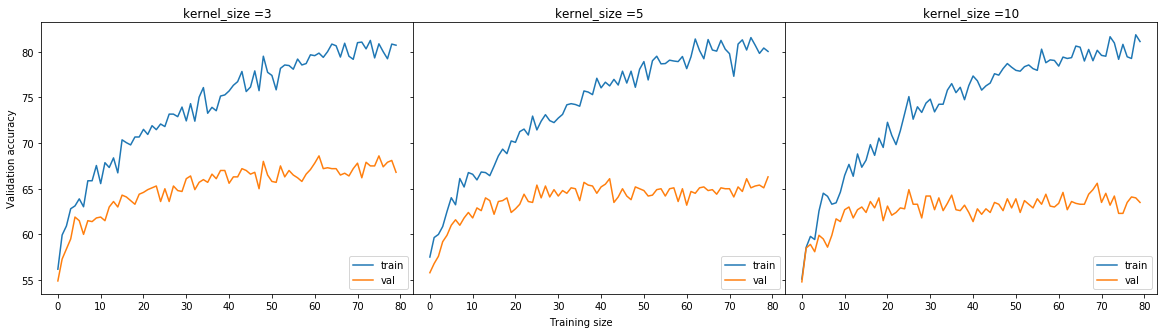

In [158]:
fig, axes = plt.subplots(1,3, sharex = True, sharey = True,figsize=(20, 5))
fig.text( 0.5, 0.04,'Training size', ha='center')
for i in range(3):
    axes[i].plot(cnn_kernel_size_tunning_train_hist[i],label='train')
    axes[i].plot(cnn_kernel_size_tunning_val_hist[i],label='val')
    axes[i].set_title('kernel_size ='+ str(kernel_size_list[i]))
    axes[i].legend(loc = 'lower right')
plt.subplots_adjust(wspace=0, hspace=None)
axes[0].set_ylabel('Validation accuracy')
plt.savefig('kernel_size tunning for CNN.png')

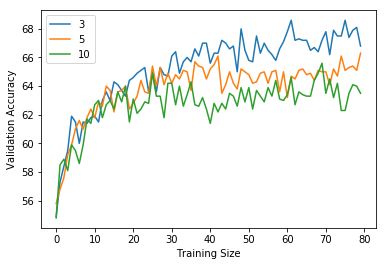

In [164]:
for i in range(3):
    plt.plot(cnn_kernel_size_tunning_val_hist[i],label=kernel_size_list[i])
plt.xlabel('Training Size')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.savefig('kernel_size tunning for CNN val acc.png')

In [ ]:
kernel_size_list = [3,5,10]
cnn_kernel_size_tunning_train_hist = []
cnn_kernel_size_tunning_val_hist = []

for kernel_size in kernel_size_list :
    print('kernel_size = {}'.format(kernel_size))

    print('CNN')
    cnn_model, train_acc_history_cnn, val_acc_history_cnn = train_cnn_model(train_loader, num_epochs = 10,
                                                                            optimizer='Adam',
                                                                            learning_rate = 3e-4 , 
                                                                            hidden_size = 600,
                                                                            kernel_size = kernel_size ,padding=1)
    cnn_kernel_size_tunning_train_hist.append(train_acc_history_cnn)
    cnn_kernel_size_tunning_val_hist.append(val_acc_history_cnn)

### 3. Learning Rate

In [82]:
lr_list = [3e-2, 3e-3,3e-4]

cnn_lr_tunning_train_hist = []
cnn_lr_tunning_val_hist = []

for lr in lr_list:
    cnn_model_lr, train_acc_history_cnn_lr, val_acc_history_cnn_lr = train_cnn_model(train_loader, num_epochs = 10,
                                                                                    optimizer='Adam',
                                                                                    learning_rate = lr , 
                                                                                    hidden_size = 300,
                                                                                    kernel_size = 3 ,padding=1)
    cnn_lr_tunning_train_hist.append(train_acc_history_cnn_lr)
    cnn_lr_tunning_val_hist.append(val_acc_history_cnn_lr)

Epoch: [1/10], Step: [385/3125], Loss: 1.2389448881149292, Train Acc:32.85891089108911, Validation Acc: 33.1
Epoch: [1/10], Step: [769/3125], Loss: 1.2076948881149292, Train Acc:33.69430693069307, Validation Acc: 33.1
Epoch: [1/10], Step: [1153/3125], Loss: 1.2076948881149292, Train Acc:34.25123762376238, Validation Acc: 33.1
Epoch: [1/10], Step: [1537/3125], Loss: 1.3014448881149292, Train Acc:34.15841584158416, Validation Acc: 33.1
Epoch: [1/10], Step: [1921/3125], Loss: 1.2076948881149292, Train Acc:32.85891089108911, Validation Acc: 33.1
Epoch: [1/10], Step: [2305/3125], Loss: 1.1764448881149292, Train Acc:33.8490099009901, Validation Acc: 33.1
Epoch: [1/10], Step: [2689/3125], Loss: 1.2701948881149292, Train Acc:33.725247524752476, Validation Acc: 33.1
Epoch: [1/10], Step: [3073/3125], Loss: 1.1764448881149292, Train Acc:35.426980198019805, Validation Acc: 33.1
Epoch: [2/10], Step: [385/3125], Loss: 1.1139448881149292, Train Acc:33.07549504950495, Validation Acc: 33.1
Epoch: [2/10

Epoch: [10/10], Step: [1537/3125], Loss: 1.3014448881149292, Train Acc:31.621287128712872, Validation Acc: 33.1
Epoch: [10/10], Step: [1921/3125], Loss: 1.0514448881149292, Train Acc:34.18935643564357, Validation Acc: 33.1
Epoch: [10/10], Step: [2305/3125], Loss: 1.1451948881149292, Train Acc:34.15841584158416, Validation Acc: 33.1
Epoch: [10/10], Step: [2689/3125], Loss: 1.2389448881149292, Train Acc:32.39480198019802, Validation Acc: 33.1
Epoch: [10/10], Step: [3073/3125], Loss: 1.3014448881149292, Train Acc:33.69430693069307, Validation Acc: 33.1
CNN Training Finished!
Val Acc 33.1
Epoch: [1/10], Step: [385/3125], Loss: 1.103511095046997, Train Acc:56.46658415841584, Validation Acc: 56.0
Epoch: [1/10], Step: [769/3125], Loss: 0.9904552698135376, Train Acc:58.632425742574256, Validation Acc: 58.8
Epoch: [1/10], Step: [1153/3125], Loss: 0.863348126411438, Train Acc:58.78712871287129, Validation Acc: 58.9
Epoch: [1/10], Step: [1537/3125], Loss: 0.9446886777877808, Train Acc:61.57178217

Epoch: [9/10], Step: [2689/3125], Loss: 0.8943040370941162, Train Acc:68.7190594059406, Validation Acc: 64.7
Epoch: [9/10], Step: [3073/3125], Loss: 0.8670399188995361, Train Acc:69.2450495049505, Validation Acc: 64.2
Epoch: [10/10], Step: [385/3125], Loss: 0.7597050666809082, Train Acc:71.9059405940594, Validation Acc: 66.0
Epoch: [10/10], Step: [769/3125], Loss: 0.8331137299537659, Train Acc:70.51361386138613, Validation Acc: 66.0
Epoch: [10/10], Step: [1153/3125], Loss: 0.86776202917099, Train Acc:69.64727722772277, Validation Acc: 65.6
Epoch: [10/10], Step: [1537/3125], Loss: 0.8063638210296631, Train Acc:72.15346534653466, Validation Acc: 65.6
Epoch: [10/10], Step: [1921/3125], Loss: 0.8609621524810791, Train Acc:68.62623762376238, Validation Acc: 65.9
Epoch: [10/10], Step: [2305/3125], Loss: 0.8773943185806274, Train Acc:69.89480198019803, Validation Acc: 65.9
Epoch: [10/10], Step: [2689/3125], Loss: 0.8012407422065735, Train Acc:69.3378712871287, Validation Acc: 64.7
Epoch: [10/

Epoch: [9/10], Step: [769/3125], Loss: 0.661710798740387, Train Acc:79.79579207920793, Validation Acc: 66.3
Epoch: [9/10], Step: [1153/3125], Loss: 0.7638991475105286, Train Acc:79.76485148514851, Validation Acc: 65.7
Epoch: [9/10], Step: [1537/3125], Loss: 0.872868001461029, Train Acc:80.01237623762377, Validation Acc: 66.2
Epoch: [9/10], Step: [1921/3125], Loss: 0.7617285847663879, Train Acc:80.10519801980197, Validation Acc: 66.0
Epoch: [9/10], Step: [2305/3125], Loss: 0.8030997514724731, Train Acc:78.7128712871287, Validation Acc: 65.9
Epoch: [9/10], Step: [2689/3125], Loss: 0.6960805654525757, Train Acc:79.73391089108911, Validation Acc: 65.9
Epoch: [9/10], Step: [3073/3125], Loss: 0.7552312612533569, Train Acc:79.33168316831683, Validation Acc: 66.1
Epoch: [10/10], Step: [385/3125], Loss: 0.691278338432312, Train Acc:80.78589108910892, Validation Acc: 65.5
Epoch: [10/10], Step: [769/3125], Loss: 0.759807825088501, Train Acc:79.64108910891089, Validation Acc: 65.9
Epoch: [10/10], 

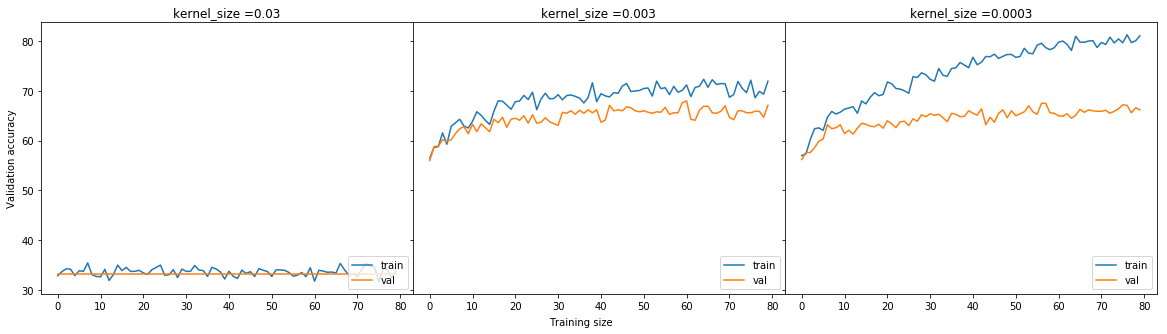

In [83]:
fig, axes = plt.subplots(1,3, sharex = True, sharey = True,figsize=(20, 5))
fig.text( 0.5, 0.04,'Training size', ha='center')
for i in range(3):
    axes[i].plot(cnn_lr_tunning_train_hist[i],label='train')
    axes[i].plot(cnn_lr_tunning_val_hist[i],label='val')
    axes[i].set_title('learning rate ='+ str(lr_list[i]))
    axes[i].legend(loc = 'lower right')
plt.subplots_adjust(wspace=0, hspace=None)
axes[0].set_ylabel('Validation accuracy')
plt.savefig('learning rate tunning for CNN.png')

#### Best Model is hidden_size = 300, kernel_size = 3, learning rate = 3e-4

In [165]:
best_rnn_model, train_acc_history_rnn, val_acc_history_rnn = train_rnn_model(train_loader, num_epochs=10,
                                                                            optimizer='Adam',
                                                                            learning_rate = 3e-4,
                                                                            hidden_size = 300)

Epoch: [1/10], Step: [385/3125], Loss: 0.9486284255981445, Train Acc:55.32178217821782, Validation Acc: 56.5
Epoch: [1/10], Step: [769/3125], Loss: 0.9498116374015808, Train Acc:58.570544554455445, Validation Acc: 57.4
Epoch: [1/10], Step: [1153/3125], Loss: 0.8788681626319885, Train Acc:56.93069306930693, Validation Acc: 56.7
Epoch: [1/10], Step: [1537/3125], Loss: 0.955979585647583, Train Acc:60.210396039603964, Validation Acc: 58.6
Epoch: [1/10], Step: [1921/3125], Loss: 0.8496319055557251, Train Acc:60.210396039603964, Validation Acc: 59.3
Epoch: [1/10], Step: [2305/3125], Loss: 0.939996600151062, Train Acc:60.36509900990099, Validation Acc: 58.4
Epoch: [1/10], Step: [2689/3125], Loss: 0.9853995442390442, Train Acc:60.9220297029703, Validation Acc: 59.9
Epoch: [1/10], Step: [3073/3125], Loss: 0.8815181255340576, Train Acc:59.870049504950494, Validation Acc: 60.5
Epoch: [2/10], Step: [385/3125], Loss: 0.7818282842636108, Train Acc:62.87128712871287, Validation Acc: 60.6
Epoch: [2/10

Epoch: [10/10], Step: [1537/3125], Loss: 0.929847776889801, Train Acc:76.82549504950495, Validation Acc: 68.9
Epoch: [10/10], Step: [1921/3125], Loss: 0.7751348614692688, Train Acc:77.13490099009901, Validation Acc: 69.5
Epoch: [10/10], Step: [2305/3125], Loss: 0.7781732082366943, Train Acc:78.1559405940594, Validation Acc: 70.4
Epoch: [10/10], Step: [2689/3125], Loss: 0.9097552299499512, Train Acc:77.93935643564356, Validation Acc: 69.3
Epoch: [10/10], Step: [3073/3125], Loss: 0.8198821544647217, Train Acc:77.97029702970298, Validation Acc: 70.7
RNN Training Finished!
Val Acc 69.8


In [169]:
torch.save(best_rnn_model.state_dict(), 'best_rnn_model.pt')

In [171]:
test_model(val_loader, best_rnn_model_reload)

69.8

In [15]:
best_cnn_model, train_acc_history_cnn, val_acc_history_cnn = train_cnn_model(train_loader, num_epochs = 10,
                                                                             optimizer='Adam',
                                                                             learning_rate = 3e-4 , 
                                                                             hidden_size = 300,
                                                                             kernel_size = 3 ,padding=1)

Epoch: [1/10], Step: [385/3125], Loss: 0.9911038279533386, Train Acc:56.652227722772274, Validation Acc: 54.9
Epoch: [1/10], Step: [769/3125], Loss: 1.0187956094741821, Train Acc:59.49876237623762, Validation Acc: 58.7
Epoch: [1/10], Step: [1153/3125], Loss: 0.8933936953544617, Train Acc:60.9220297029703, Validation Acc: 59.2
Epoch: [1/10], Step: [1537/3125], Loss: 1.0058757066726685, Train Acc:60.210396039603964, Validation Acc: 57.0
Epoch: [1/10], Step: [1921/3125], Loss: 0.8917572498321533, Train Acc:63.304455445544555, Validation Acc: 60.6
Epoch: [1/10], Step: [2305/3125], Loss: 0.8293516635894775, Train Acc:64.17079207920793, Validation Acc: 59.7
Epoch: [1/10], Step: [2689/3125], Loss: 1.016211986541748, Train Acc:65.00618811881188, Validation Acc: 59.6
Epoch: [1/10], Step: [3073/3125], Loss: 0.7547774910926819, Train Acc:65.40841584158416, Validation Acc: 61.7
Epoch: [2/10], Step: [385/3125], Loss: 0.853392481803894, Train Acc:65.47029702970298, Validation Acc: 62.1
Epoch: [2/10]

Epoch: [10/10], Step: [1537/3125], Loss: 0.7277270555496216, Train Acc:80.1980198019802, Validation Acc: 65.8
Epoch: [10/10], Step: [1921/3125], Loss: 0.6537578701972961, Train Acc:81.34282178217822, Validation Acc: 65.6
Epoch: [10/10], Step: [2305/3125], Loss: 0.748103141784668, Train Acc:80.29084158415841, Validation Acc: 64.7
Epoch: [10/10], Step: [2689/3125], Loss: 1.013669729232788, Train Acc:80.16707920792079, Validation Acc: 64.9
Epoch: [10/10], Step: [3073/3125], Loss: 0.7618011236190796, Train Acc:79.95049504950495, Validation Acc: 64.8
CNN Training Finished!
Val Acc 66.3


In [17]:
torch.save(best_cnn_model.state_dict(), 'best_cnn_model.pt')

In [18]:
best_rnn_model = RNN(input_size = 300, hidden_size = 300, output_size = 3)
best_rnn_model.load_state_dict(torch.load('best_rnn_model.pt'))

# 7. Highlight 3 correct and 3 incorrect predictions

In [19]:
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=False)

In [49]:
rnn_predictions = []
cnn_predictions = []
best_rnn_model.eval()
best_cnn_model.eval()
for i, (x1, x2, x1_lengths, x2_lengths, labels) in enumerate(val_loader):
    if i>= 1: break #only search in the first batch
    x1_batch, x2_batch, x1_length_batch, x2_length_batch, label_batch = x1, x2, x1_lengths, x2_lengths, labels
    rnn_outputs = best_rnn_model(x1_batch,x2_batch,x1_lengths,x2_lengths) 
    cnn_outputs = best_cnn_model(x1_batch,x2_batch,x1_lengths,x2_lengths) 
    
    #get the predicted labels
    rnn_predicted = rnn_outputs.max(1, keepdim=True)[1] 
    cnn_predicted = cnn_outputs.max(1, keepdim=True)[1] 
    rnn_predictions.append(rnn_predicted)
    cnn_predictions.append(cnn_predicted)

In [51]:
rnn_prediction = [item[0] for item in rnn_predictions[0].numpy().tolist()]
cnn_prediction = [item[0] for item in cnn_predictions[0].numpy().tolist()]
print(rnn_prediction)
print(cnn_prediction)

[0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 2, 0, 0, 2, 2, 2, 1, 0, 2, 2, 0, 1, 1, 2, 0, 0, 0, 2, 2, 1]
[0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2]


In [52]:
premise, hypothesis, labels = data_split(val_path)

In [54]:
idx2labels = {0:'entailment', 
              1: 'contradiction', 
              2: 'neutral'}
# premise_val, hypothesis_val, label_val

print('RNN Predictions: ')
correct = 0
incorrect = 0
for i in range(BATCH_SIZE):  
    if(label_val[i] == rnn_prediction[i]):
        print('correct prediction{}'.format(correct+1))
        print('prediction:{}, label:{}'.format(idx2labels[rnn_prediction[i]],idx2labels[label_val[i]]))
        print('premise:',' '.join(premise[i]))
        print('hypothesis',' '.join(hypothesis[i]))
        print('\n')
        correct +=1
    if(correct > 2):break

for i in range(BATCH_SIZE):  
    if(label_val[i] != rnn_prediction[i]):
        print('incorrect prediction{}'.format(incorrect+1))
        print('prediction:{}, label:{}'.format(idx2labels[rnn_prediction[i]],idx2labels[label_val[i]]))
        print('premise:',' '.join(premise[i]))
        print('hypothesis:',' '.join(hypothesis[i]))
        print('\n')
        incorrect +=1
    if(incorrect > 2):break

RNN Predictions: 
correct prediction1
prediction:entailment, label:entailment
premise: Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .
hypothesis Multiple people are on a subway together , with each of them doing their own thing .


correct prediction2
prediction:entailment, label:entailment
premise: bicycles stationed while a group of people socialize .
hypothesis People get together near a stand of bicycles .


correct prediction3
prediction:entailment, label:entailment
premise: Man in overalls with two horses .
hypothesis a man in overalls with two horses


incorrect prediction1
prediction:entailment, label:contradiction
premise: Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .
hypothesis: There are two women standing on the stage


in

In [55]:
print('CNN Predictions: ')
correct = 0
incorrect = 0
for i in range(BATCH_SIZE):  
    if(label_val[i] == cnn_prediction[i]):
        print('correct prediction{}'.format(correct+1))
        print('prediction:{}, label:{}'.format(idx2labels[cnn_prediction[i]],idx2labels[label_val[i]]))
        print('premise:',' '.join(premise[i]))
        print('hypothesis',' '.join(hypothesis[i]))
        print('\n')
        correct +=1
    if(correct > 2):break

for i in range(BATCH_SIZE):  
    if(label_val[i] != cnn_prediction[i]):
        print('incorrect prediction{}'.format(incorrect+1))
        print('prediction:{}, label:{}'.format(idx2labels[cnn_prediction[i]],idx2labels[label_val[i]]))
        print('premise:',' '.join(premise[i]))
        print('hypothesis:',' '.join(hypothesis[i]))
        print('\n')
        incorrect +=1
    if(incorrect > 2):break

CNN Predictions: 
correct prediction1
prediction:entailment, label:entailment
premise: Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .
hypothesis Multiple people are on a subway together , with each of them doing their own thing .


correct prediction2
prediction:entailment, label:entailment
premise: bicycles stationed while a group of people socialize .
hypothesis People get together near a stand of bicycles .


correct prediction3
prediction:entailment, label:entailment
premise: Man in overalls with two horses .
hypothesis a man in overalls with two horses


incorrect prediction1
prediction:entailment, label:contradiction
premise: Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .
hypothesis: There are two women standing on the stage


in

# 8. Evaluate on MultiNLI

In [59]:
def split_mnli(filename):
    '''
    splits the datafile into premise, hypothesis and corresponding labels
    Returns:
    premise: a list of premise sentences
    hypoth: a list of hypothesis sentences
    labels: a list of labels
    genre2indices: a dictionary where key is genre, value is the corresponding indices of data points
    genre_list: a list of unique genre names
    '''
    premise = []
    hypoth = []
    labels = []
    genres = []

    with open (filename,'r') as tsvfile:
        next(tsvfile) #skip the first line header
        tsvreader = csv.reader(tsvfile,delimiter='\t')
        for line in tsvreader:
            premise.append(line[0].split())
            hypoth.append(line[1].split())
            labels.append(line[2])
            genres.append(line[3])
    
    #get the list of unique genres
    genre_list = list(set(genres))
    genre2indices = {}
    for genre in genre_list:
        indices = [i for i, x in enumerate(genres) if x == genre ]
        genre2indices[genre] = indices
    
    return premise, hypoth, labels, genre2indices, genre_list

mnli_premise, mnli_hypoth, mnli_labels, genre2indices, genre_list = split_mnli('hw2_data/mnli_val.tsv')


In [69]:
loaded_embed, words2idx, idx2words = load_pretrained_embed('wiki-news-300d-1M.vec')
mnli_premise_embed = textdata2vectors(mnli_premise,words2idx,loaded_embed)
mnli_hypothesis_embed = textdata2vectors(mnli_hypoth,words2idx,loaded_embed)
mnli_labels_embed = label2idx(mnli_labels)

In [71]:
mnli_rnn_acc_history = []
mnli_cnn_acc_history = []

for genre in genre_list:
    indices = genre2indices[genre]
    
    mnli_val_dataset = Dataset(mnli_premise_embed[indices], mnli_hypothesis_embed[indices], mnli_labels_embed[indices])
    mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                             batch_size=BATCH_SIZE,
                                             collate_fn = collate_func,
                                             shuffle=True)
    
    mnli_rnn_acc_history.append(test_model(mnli_val_loader, best_rnn_model))
    mnli_cnn_acc_history.append(test_model(mnli_val_loader,best_cnn_model))

print('genre list: {}'.format(genre_list))
print('best rnn model evaluated on mnli val: {}'.format(mnli_rnn_acc_history))
print('best cnn model evaluated on mnli val: {}'.format(mnli_cnn_acc_history))

genre list: ['travel', 'fiction', 'telephone', 'slate', 'government']
best rnn model evaluated on mnli val: [42.66802443991853, 46.231155778894475, 43.98009950248756, 41.616766467065865, 44.19291338582677]
best cnn model evaluated on mnli val: [43.4826883910387, 46.53266331658291, 46.26865671641791, 41.71656686626746, 40.846456692913385]


In [92]:
fictionidx = genre2indices['fiction']
fiction_lens = [len(mnli_premise[i]) for i in fictionidx]
sum(fiction_lens)/len(fiction_lens)

31.711557788944724

In [94]:
slateidx = genre2indices['slate']
slate_lens = [len(mnli_premise[i]) for i in slateidx]
sum(slate_lens)/len(slate_lens)

21.881237524950098

In [95]:
governidx = genre2indices['government']
govern_lens = [len(mnli_premise[i]) for i in governidx]
sum(govern_lens)/len(govern_lens)

23.505905511811022

In [96]:
teleidx = genre2indices['telephone']
tele_lens = [len(mnli_premise[i]) for i in teleidx]
sum(tele_lens)/len(tele_lens)

24.586069651741294